# the data cleaning attempt

gagan d

In [2]:
import os
import re
import statistics
import cv2
import tensorflow as tf
import numpy as np
from sklearn.cluster import MiniBatchKMeans
%matplotlib inline
from matplotlib import pyplot as plt
from datetime import datetime

## Load all WSI paths

In [3]:
def load_all_img_paths(dir_to_search):
    filepaths = []
    for subdir, dirs, files in os.walk(dir_to_search):
        for file in files:
            if is_wsi(file):
                filepath = os.path.join(subdir, file)
                filepaths.append(filepath)
    return filepaths

In [4]:
def is_wsi(img_path):
    '''
    Checks if filename is like 145_12.tiff.
    '''
    filename = os.path.basename(img_path)
    wsi_tiff_regex = '\d+_\d+.tif'
    x = re.search(wsi_tiff_regex, filename)
    if x is None:
        return False
    if filename.startswith('._'):
        return False
    return True

In [5]:
# path = '/srv/tank/mcw/wsi'
path = '/srv/tank/mcw/Prostates'

In [6]:
wsi_paths = load_all_img_paths(path)

In [7]:
len(wsi_paths)

20

In [99]:
for x in wsi_paths:
    print(x)

/srv/tank/mcw/Prostates/146_7/146_7.tiff
/srv/tank/mcw/Prostates/216_11/216_11.tiff
/srv/tank/mcw/Prostates/149_8/149_8.tiff
/srv/tank/mcw/Prostates/209_14/209_14.tiff
/srv/tank/mcw/Prostates/150_6/150_6.tiff
/srv/tank/mcw/Prostates/152_8/152_8.tiff
/srv/tank/mcw/Prostates/145_11/145_11.tiff
/srv/tank/mcw/Prostates/163_8/163_8.tiff
/srv/tank/mcw/Prostates/179_8/179_8.tiff
/srv/tank/mcw/Prostates/181_9/181_9.tiff
/srv/tank/mcw/Prostates/151_8/151_8.tiff
/srv/tank/mcw/Prostates/164_8/164_8.tiff
/srv/tank/mcw/Prostates/148_9/148_9.tiff
/srv/tank/mcw/Prostates/215_10/215_10.tiff
/srv/tank/mcw/Prostates/211_13/211_13.tiff
/srv/tank/mcw/Prostates/212_14/212_14.tiff
/srv/tank/mcw/Prostates/147_10/147_10.tiff
/srv/tank/mcw/Prostates/210_2/210_2.tiff
/srv/tank/mcw/Prostates/180_11/180_11.tiff
/srv/tank/mcw/Prostates/214_14/214_14.tiff


## Downscaling & Create Masks

In [8]:
def create_image_mask(img, print_time=True):
    starttime = datetime.now()
    img_pixel_list = img.reshape((img.shape[0] * img.shape[1], 3))
    cluster = MiniBatchKMeans(2, tol=0.2)
    cluster.fit(img_pixel_list.astype('uint8'))
    pixel_labels = cluster.labels_
    img_mask = pixel_labels.reshape((img.shape[0],img.shape[1]))
    if print_time:
        print((datetime.now()-starttime).seconds)
    return img_mask

In [9]:
def downsample_img(img, num_downsamples=1):
    ds_img = img
    for i in range(0,num_downsamples):
        ds_img = cv2.pyrDown(ds_img)
    return ds_img

In [10]:
def upsample_img(img, num_ups=1):
    up_img = img
    for i in range(0, num_ups):
        up_img = cv2.pyrUp(up_img)
    return up_img

In [11]:
wsi = wsi_paths[5]
print(wsi)

/srv/tank/mcw/Prostates/152_8/152_8.tiff


In [12]:
wsi_img = cv2.imread(wsi)

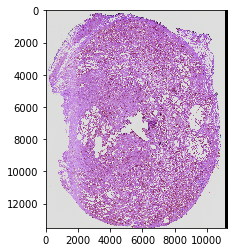

In [112]:
plt.imshow(wsi_img)

In [113]:
wsi_img.shape

(13500, 11250, 3)

In [121]:
downscaled_img = downsample_img(wsi_img)

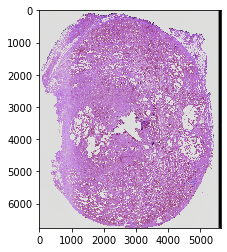

In [123]:
plt.imshow(downscaled_img)

In [124]:
downscaled_img.shape

(6750, 5625, 3)

(3375, 2813, 3)


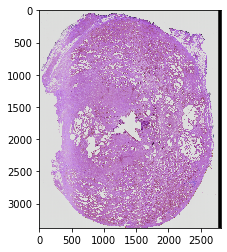

In [126]:
downscaled_2x = downsample_img(downscaled_img)
print(downscaled_2x.shape)
plt.imshow(downscaled_2x)

### 3x

In [139]:
downscaled_3x = downsample_img(wsi_img, 3)

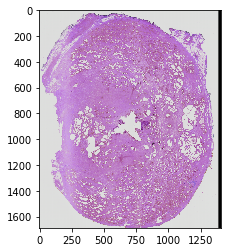

In [140]:
plt.imshow(downscaled_3x)

8


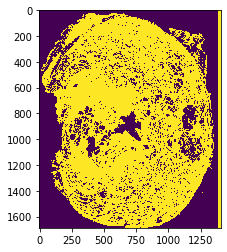

In [147]:
mask3x = create_image_mask(downscaled_3x)
plt.imshow(mask3x)

### 4x

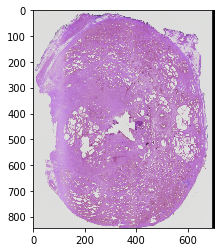

In [13]:
downscaled_4x = downsample_img(wsi_img, 4)
plt.imshow(downscaled_4x)

2


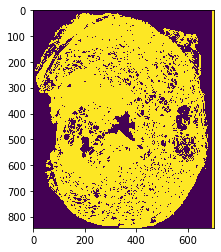

In [14]:
mask_4x = create_image_mask(downscaled_4x)
plt.imshow(mask_4x)

### WSI -> Mask Ratios

In [15]:
s_shape = mask_4x.shape
print(s_shape)

(844, 704)


In [16]:
w_shape = wsi_img.shape
print(w_shape)

(13500, 11250, 3)


In [17]:
y_ratio = w_shape[0]/s_shape[0]
print(y_ratio)

15.995260663507109


In [18]:
x_ratio = w_shape[1]/s_shape[1]
print(x_ratio)

15.980113636363637


### Determine Tissue Classification

In [19]:
def get_img_center(img,center_size=.80):
    y = len(img)
    x = len(img[0])
    x_center_start = int(x*(1-center_size))
    x_center_end = int(x*(center_size))
    y_center_start = int(y*(1-center_size))
    y_center_end = int(y*(center_size))
    center_img = img[y_center_start:y_center_end,x_center_start:x_center_end]
    return center_img

In [73]:
def most_common_pixel_in_img(img):
    mode = statistics.mode(img.flatten())
    return mode

## Crawl Mask and Crop

In [79]:
def mask_crop_to_wsi_crop(mask_crop,wsi,mask_x,mask_y,x_ratio,y_ratio,target_png_shape):
    wsi_x = mask_x*x_ratio
    wsi_y = mask_y*y_ratio
    return wsi[wsi_y:wsi_y+target_png_shape,wsi_x:wsi_x+target_png_shape]

In [114]:
def crawl(mask, wsi, target_png_shape=1024):
    w_shape = wsi.shape
    m_shape = mask.shape
    y_ratio = int(w_shape[0]/m_shape[0])
    x_ratio = int(w_shape[1]/m_shape[1])
    mask_crops = []
    wsi_crops = []
    wsi_crops_passed = []
    mask_shape = int(target_png_shape/16) #if scale is 4x
    tissue_classification_color = most_common_pixel_in_img(mask)
    for y in range(0,len(mask),50):
        for x in range(0,len(mask[0]),50):
            mask_crop = mask[y:y+mask_shape,x:x+mask_shape]
            wsi_crop = mask_crop_to_wsi_crop(mask_crop, wsi, x, y, x_ratio, y_ratio, target_png_shape)
            mask_crops.append((mask_crop, wsi_crop))
            if most_common_pixel_in_img(mask_crop)==tissue_classification_color:
                wsi_crops.append(wsi_crop)
            else:
                wsi_crops_passed.append(wsi_crop)
    return wsi_crops, wsi_crops_passed, mask_crops

In [115]:
crops = crawl(mask_4x, wsi_img)

### CROPPED OUT WSI IMAGES

In [116]:
len(crops[0])

187

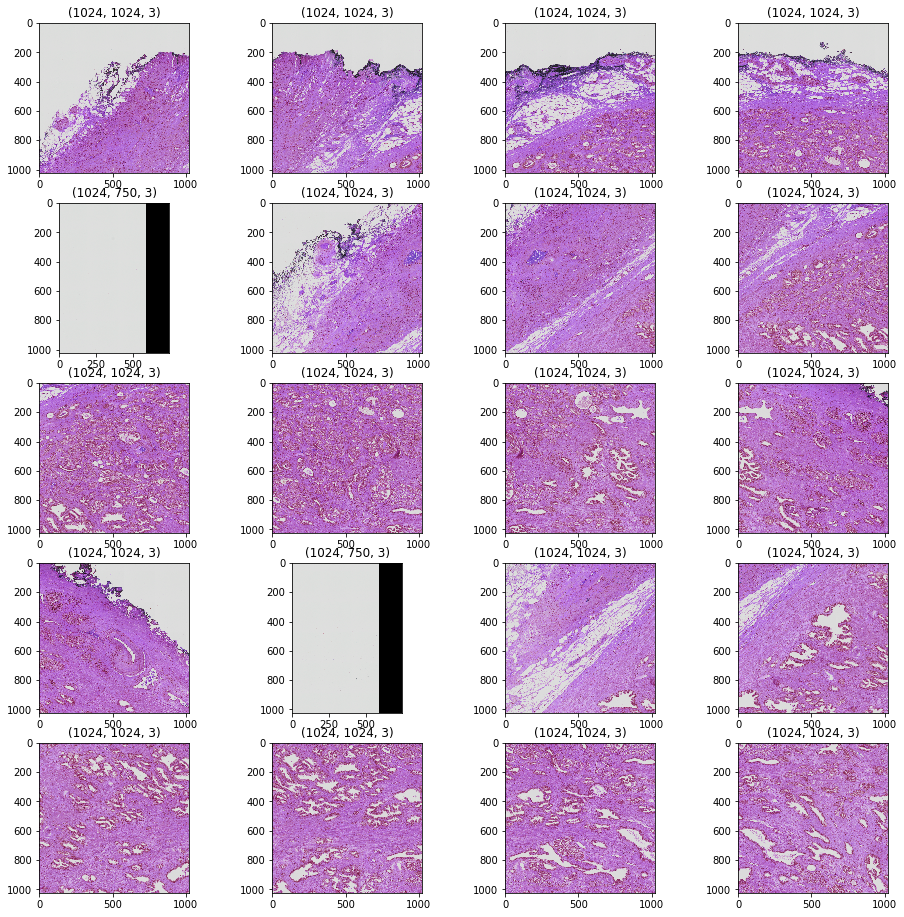

In [117]:
n_row = 5
n_col = 4
_, axs = plt.subplots(n_row, n_col, figsize=(16, 16))
axs = axs.flatten()
for img, ax in zip(crops[0][0:20], axs):
    ax.set_title(img.shape)
    ax.imshow(img)
plt.show()

### SKIPPED WSI IMAGES

In [118]:
len(crops[1])

68

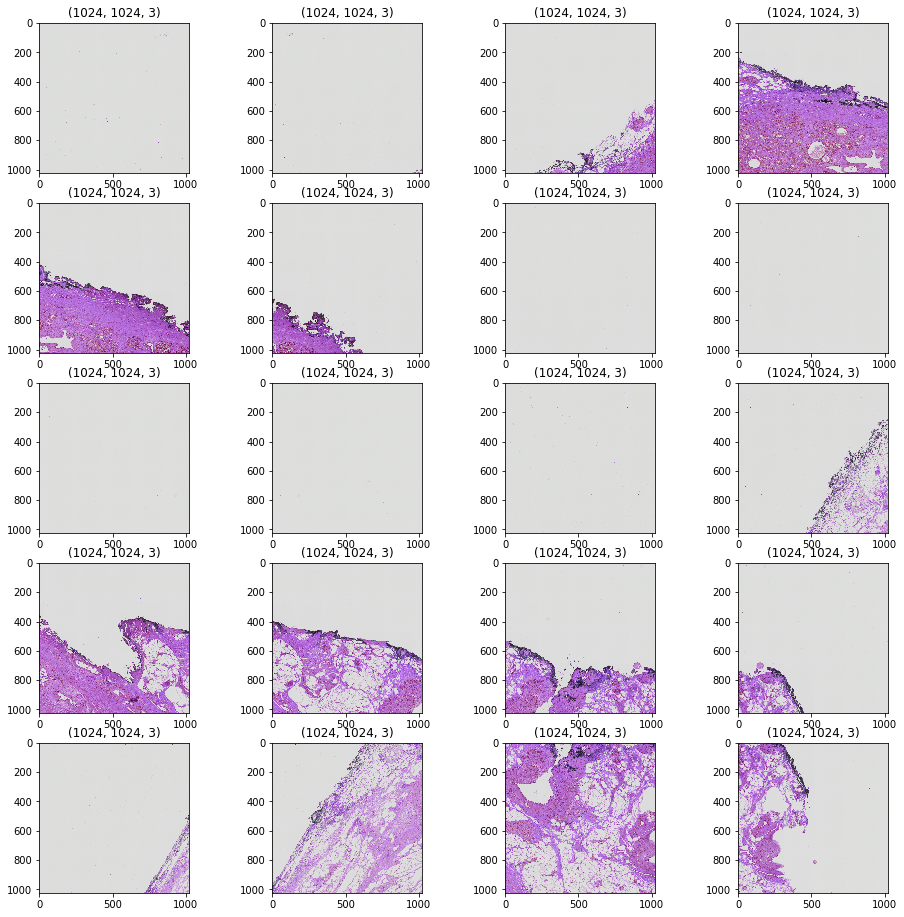

In [119]:
n_row = 5
n_col = 4
_, axs = plt.subplots(n_row, n_col, figsize=(16, 16))
axs = axs.flatten()
for img, ax in zip(crops[1][0:20], axs):
    ax.set_title(img.shape)
    ax.imshow(img)
plt.show()

### IMAGE MASK CROPS

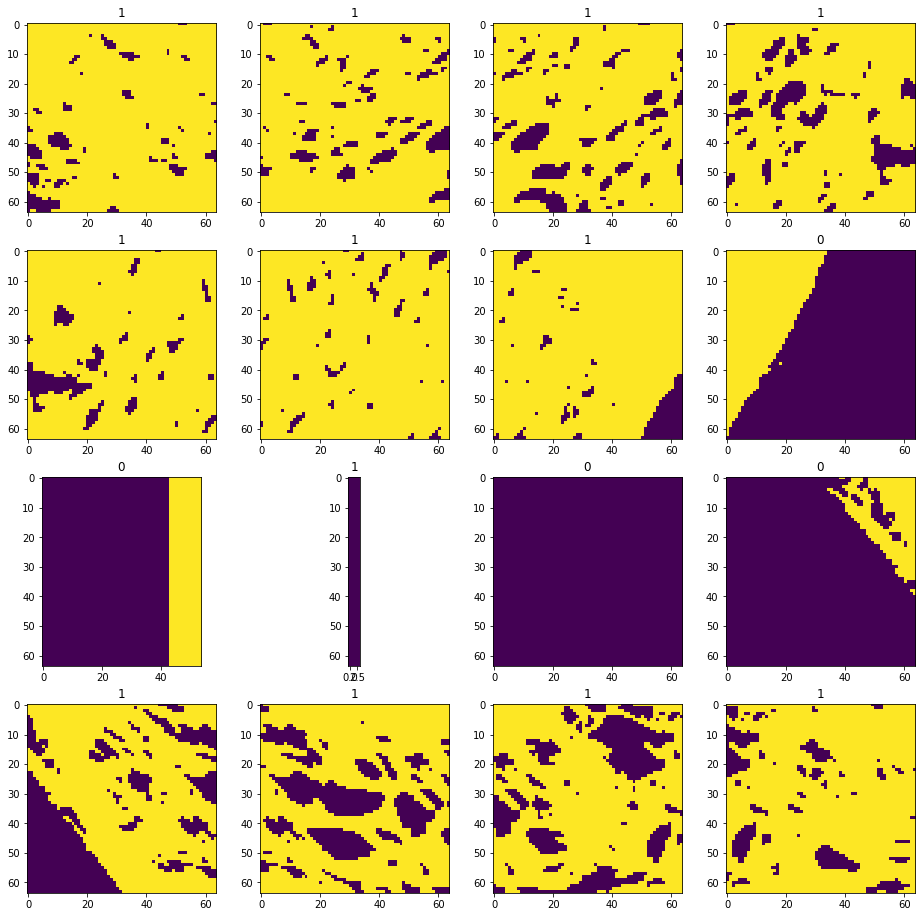

In [78]:
n_row = 4
n_col = 4
_, axs = plt.subplots(n_row, n_col, figsize=(16, 16))
axs = axs.flatten()
for img, ax in zip(crops[200:216], axs):
    ax.set_title(most_common_pixel_in_img(img))
    ax.imshow(img)
plt.show()